# Method: LSTM 
# Dataset: Lorenz-96, F = 8
# Purpose: Prediction

# 1. Set-up

In [1]:
# GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Package
import sys
sys.path.append("../..")

In [2]:
from create_data import load_data
from utils import * # Number of testing samples
import numpy as np
import matplotlib.pyplot as plt
from time import time
from functools import partial

import jax
import jax.numpy as jnp
from jax.nn.initializers import glorot_normal, normal
from jax.example_libraries import optimizers

In [3]:
SEED = 42

In [4]:
train, test = load_data("Lorenz 96, F = 8", "../../data/lorenz8", 0.5)

In [5]:
print(f"Train size: {train.data.shape}")
print(f"Test size: {test.data.shape}")

Train size: (90000, 40)
Test size: (90000, 40)


**Create test set**

In [10]:
L_forecast_test = 400   # steps to forecast forward (when testing)

In [11]:
np.random.seed(1)

data_test = test.data

T_test, data_dim = data_test.shape
possible_idx = T_test - (L_forecast_test + 1) # minus number of steps forward, and the warm-up period
T_indices = np.random.randint(0, possible_idx, size = NUM_TEST)

t_past_batch = np.repeat(T_indices[:, None], WARM_UP_TEST, axis = 1).astype(int) # 2000 warmup 
t_pred_batch = (T_indices[:, None] + np.arange(1, 1 + L_forecast_test)[None, :].astype(int))

X_test = data_test[t_past_batch]
y_test = data_test[t_pred_batch]

In [12]:
print(f"Test input size: {X_test.shape}")  # Number of test points x input length x dim
print(f"Test output size: {y_test.shape}") # Number of test points x horizon x dim

Test input size: (100, 2000, 40)
Test output size: (100, 400, 40)


# 2. LSTM Implementation

In [14]:
def LSTM(h_dim, data_dim, W_init = glorot_normal(), b_init = normal()):
    """
    args:
    ====
     h_dim: dimension of the internal state
     data_dim: dimensionity of the time series

    outputs:
    ======
     init_fun: function to initialize the parameters
     process: function to process a time-series and compute the final prediction and final internal state
     forecast: function that, given a pair (internal-state, input), computes the next T predictions
    """
    
    def init_fun(rng):
        """
        This function initialize the weights of the RNN
        
        args:
        ====
         rng: jax RNG
         
        outputs:
        ======
         params: a tuple of parameters
        """
        
        # Forget Layer
        k1, k2, k3 = jax.random.split(rng, num = 3)
        fU = W_init(k1, (h_dim, data_dim))
        fW = W_init(k2, (h_dim, h_dim)) 
        fb = b_init(k3, (h_dim,))
        
        # Input Layer
        k1, k2, k3 = jax.random.split(rng, num = 3)
        iU = W_init(k1, (h_dim, data_dim))
        iW = W_init(k2, (h_dim, h_dim))
        ib = b_init(k3, (h_dim,))
        
        # Candidate layer
        k1, k2, k3 = jax.random.split(rng, num = 3)
        gU = W_init(k1, (h_dim, data_dim))
        gW = W_init(k2, (h_dim, h_dim))
        gb = b_init(k3, (h_dim,))
        
        # Output layer
        k1, k2, k3 = jax.random.split(rng, num = 3)
        oU = W_init(k1, (h_dim, data_dim))
        oW = W_init(k2, (h_dim, h_dim))
        ob = b_init(k3, (h_dim,))
        
        # Dense layer (hidden -> y)
        k1, k2 = jax.random.split(rng, num = 2)
        dO = W_init(k1, (data_dim, h_dim))
        db = b_init(k2, (data_dim,))
                
        params = fU, fW, fb, iU, iW, ib, gU, gW, gb, oU, oW, ob, dO, db
        return params
    
    def process(params, time_series):
        """
        This function takes a time-series in input, pass it through the RNN, 
        and finally outputs the last prediction and internal state
        
        args:
        ====
         params: tuple of parameters
         time_series: data of dimension (T, dim_data)
         
        outputs:
        =======
         c_final: jax vector of dimension nn_size
         h_final: jax vector of dimension nn_size
         pred_traj[-1]: last prediction
        """
        
        fU, fW, fb, iU, iW, ib, gU, gW, gb, oU, oW, ob, dO, db = params 
        
        c_zero = np.zeros((h_dim, ))
        h_zero = np.zeros((h_dim, ))
        
        # forward pass
        def process_internal(start, x):
            c, h = start
            
            forget_gate = sigmoid(jnp.dot(fU, x) + jnp.dot(fW, h) + fb)
            input_gate = sigmoid(jnp.dot(iU, x) + jnp.dot(iW, h) + ib)
            cand_gate = jnp.tanh(jnp.dot(gU, x) + jnp.dot(gW, h) + gb)
            c_new = sigmoid(forget_gate * c + input_gate * cand_gate)    
            output_gate = sigmoid(jnp.dot(oU, x) + jnp.dot(oW, h) + ob)
            h_new = jnp.tanh(c_new) * output_gate
            y = x + dO @ h_new + db
            
            return (c_new, h_new), y
        (c_final, h_final), pred_traj = jax.lax.scan(process_internal, (c_zero, h_zero), time_series)
        return (c_final, h_final), pred_traj[-1]
    
    
    def forecast(params, internal_states, x_input, horizon):
        """
        This function takes in an internal state and a first input and produces 
        prediction over a finite horizon.
        
        args:
        ====
         params: tuple of parameters
         internal_states = (c_internal, h_internal): internal state values of c and h
         x_input: jax vector of dimension dim_data
         horizon: horizon of the prediction
         
        outputs:
        =======
         preds: a trajectory of prediction of dimension (horison, dim_data) 
        """
        c_internal, h_internal = internal_states
        # extract parameters
        fU, fW, fb, iU, iW, ib, gU, gW, gb, oU, oW, ob, dO, db = params 
        
        # forward pass
        def forecast_internal(triple_c_h_x, _ ):
            cell, hidden, x = triple_c_h_x
            
            forget_gate = sigmoid(jnp.dot(fU, x) + jnp.dot(fW, hidden) + fb)
            input_gate = sigmoid(jnp.dot(iU, x) + jnp.dot(iW, hidden) + ib)
            cand_gate = jnp.tanh(jnp.dot(gU, x) + jnp.dot(gW, hidden) + gb)
            c_new = sigmoid(forget_gate * cell + input_gate * cand_gate)    
            output_gate = sigmoid(jnp.dot(oU, x) + jnp.dot(oW, hidden) + ob)
            h_new = jnp.tanh(c_new) * output_gate
            y = x + dO @ h_new + db
            
            return (c_new, h_new, y), y
        
        _, pred_traj = jax.lax.scan(forecast_internal, (c_internal, h_internal, x_input), None, length=horizon)
        
        # return the trajectory of predictions
        return pred_traj
    
    return init_fun, process, forecast

In [15]:
def get_parameters(nn_size, seed, batch_size, L_past, L_forecast_train, 
                   num_epoch, lr_schedule, early_stopping = EARLY_STOPPING, 
                  early_stopping_baseline = 1.):
    assert len(num_epoch) == len(lr_schedule)
    def training(x, y, init_params):
        @jax.jit
        def step(i, opt_state, x_batch, y_batch):
            params = get_params(opt_state)
            value, g = jax.value_and_grad(mse)(params, x_batch, y_batch)
            opt_state = opt_update(i, g, opt_state)
            return get_params(opt_state), opt_state, value
        
        @partial(jax.jit, static_argnums=2)
        def make_forecast(params, x_batch, horizon):
            # pass the data through the RNN. 
            # note that "preds" is the first forecasts
            hs, preds = process_batch(params, x_batch)
            # compute the (L_forecast-1) next forecasts
            y_pred = forecast_batch(params, hs, preds, horizon-1)
            #stick all the forecasts together
            y_pred = jnp.concatenate([preds[:, None,:], y_pred], axis=1)

            return y_pred

        @jax.jit
        def mse(params, x_batch, y_truth):
            """
            For each time-series in a batch, forecasts over a finite horizon 
            and compute the MSE.

            args:
            ====
             params: neural parameters
             x_batch: a batch of inputs with dimension (batch_size, T_past, dim_data)
             y_truth: a batch of values to forecasts with dimension (batch_size, T_future, dim_data)

            outputs:
            =======
             MSE: MSE between forecasts and targets
            """

            # horizon of the forecast
            L_forecast = y_truth.shape[1]    
            y_pred = make_forecast(params, x_batch, L_forecast)

            #compute MSE
            error = y_pred - y_truth
            mu_loss = jnp.mean(error**2)
            return mu_loss 
        
        start = time()
        
        best_params = init_params
        overall_best_mse = 999999999
        
        # train/val split
        t_size = int(0.9 * train_size)
        v_size = train_size - t_size
        T_indices_val = np.arange(t_size, train_size - (L_forecast_test + L_past))
        t_start_val = T_indices_val[::10]
        t_past_batch_val = (t_start_val[:,None] + np.arange(L_past)[None,:]).astype(int) 
        t_pred_batch_val = (t_start_val[:,None] + np.arange(L_past,L_past+L_forecast_test)[None,:]).astype(int) 
        x_val = x[t_past_batch_val]
        y_val = y[t_pred_batch_val]
        
        
        print("Backpropogation start", end = "\n\n")
        for i, lr in enumerate(lr_schedule):
            opt_init, opt_update, get_params = optimizers.adam(step_size = lr) 
            opt_state = opt_init(best_params)
            counter = 0
            best_mse = 999999999
            
            for epoch in range(num_epoch[i]):
                e_start = time()
                
                # randomize the order of the training data
                T_indices = np.arange(t_size - (L_forecast_train + L_past))
                np.random.shuffle(T_indices)
                
                # training
                loss_epoch_train = []
                
                for k in range(t_size // batch_size + 1):
                    # create a batch of data
                    t_start = T_indices[np.arange(k*batch_size, (k+1)*batch_size).astype(int) % len(T_indices)] # start of each time series in the batch
                    # create 2d array of dimension (batch_size, L_past) containing all the time indices
                    t_past_batch = (t_start[:,None] + np.arange(L_past)[None,:]).astype(int) # transposes data
                    t_pred_batch = (t_start[:,None] + np.arange(L_past,L_past+L_forecast_train)[None,:]).astype(int) 

                    #create batch of dimension (batch_size, L_past, data_dim)
                    x_batch = x[t_past_batch]  
                    y_batch = y[t_pred_batch]

                    params, opt_state, loss_current = step(k, opt_state, x_batch, y_batch) # update
                    loss_epoch_train.append(loss_current)
                
                mse_train = np.mean(loss_epoch_train)
                
                # validation             
                mse_val = mse(params, x_val, y_val)
                
                if  best_mse > mse_val: # Improvement
                    counter = 0
                    best_mse = mse_val
                    best_params = params
                else:
                    counter += 1
                
                e_end = time()
                if (epoch + 1) % 10 == 0 or (counter == 0 and epoch >= 50):
                    print(f"Epoch {epoch + 1}: Time taken = {e_end - e_start:.2f} | Train loss = {mse_train:.7f} | Val loss = {mse_val: .7f}")
                
                if best_mse < early_stopping_baseline and counter >= early_stopping:
                    print(f"EARLY STOPPING. Epoch {epoch + 1}: Train loss = {mse_train:.7f} | Val loss = {mse_val: .7f}")
                    break
            print(f"Best Validation MSE: {best_mse:.7f}")
            
            if best_mse < overall_best_mse: # Best round so far
                print("IMPROVED VALIDATION MSE")
                overall_best_mse = best_mse
                overall_best_params = best_params
            print()
        
        end = time()
        print(f"Total time: {end - start:.2f}")
        
        return overall_best_params

    start = time()
    x, y = train.data[:-1], train.data[1:]
    train_size, data_dim = x.data.shape
    
    np.random.seed(seed)
    key = jax.random.PRNGKey(seed)
    
    # Initialize LSTM
    init_fun, process, forecast = LSTM(nn_size, data_dim)       # LSTM Network
    process_batch = jax.jit(jax.vmap(process, in_axes=(None,0)))
    forecast_batch = jax.jit(jax.vmap(forecast, in_axes=(None,0,0,None)), static_argnums=3)
    init_params = init_fun(key)
    
    final_params = training(x, y, init_params)
    end = time()
    print(f"Complete. Time taken: {end - start:.2f}s")
    
    return final_params, (process_batch, forecast_batch)

In [16]:
def get_test_pred(data_test, params, lstm_fx):  
    @partial(jax.jit, static_argnums=2)
    def make_forecast(params, x_batch, horizon):
        pbatch, fbatch = lstm_fx
        # pass the data through the RNN. 
        # note that "preds" is the first forecasts
        hs, preds = pbatch(params, x_batch)
        # compute the (L_forecast-1) next forecasts
        y_pred = fbatch(params, hs, preds, horizon-1)
        #stick all the forecasts together
        y_pred = jnp.concatenate([preds[:, None,:], y_pred], axis=1)

        return y_pred

    @jax.jit
    def loss(params, x_batch, y_truth):
        """
        For each time-series in a batch, forecasts over a finite horizon 
        and compute the MSE.

        args:
        ====
         params: neural parameters
         x_batch: a batch of inputs with dimension (batch_size, T_past, dim_data)
         y_truth: a batch of values to forecasts with dimension (batch_size, T_future, dim_data)

        outputs:
        =======
         MSE: MSE between forecasts and targets

        """

        # horizon of the forecast
        L_forecast = y_truth.shape[1]    
        y_pred = make_forecast(params, x_batch, L_forecast)

        #compute MSE
        error = y_pred - y_truth
        return jnp.mean(error**2)
    
    start = time()
    num_data_test, L_past, data_dim = data_test.shape # testing ex, # steps used before, dim of data
    mu_pred = make_forecast(params, data_test, L_forecast_test)
    end = time()
    print(f"Testing complete. Time taken: {end - start:.2f}")
    return np.array(mu_pred)

# 3. Parameter tuning

There are 3 parameters to tune
- nn_size [100, 500, 1000, 1500] - size of the hidden layer
- L_forecast_train [4, 8, 16] - steps forward considered when calculating loss during training
- L_past [1, 8, 16] - length of time series used as input during training 

As a full grid search will be computationally expensive, nn_size is first tuned using a fixed L_forecast_train and L_past, then a grid search is performed on the optimal nn_size

## 3.1 nn_size

**Parameters**
- nn_size = [100, 500, 1000, 1500]
- L_forecast_train = 8
- L_past = 4

In [12]:
L_forecast_train = 8
L_past = 4
b_size = 128 # Batch size
lr_list = [1e-2, 1e-3, 1e-4] # Learning rate schedule
epoch_list = [200, 400, 200]  # Number of epochs for each learning rate

### 3.1.1 nn_size = 100

In [13]:
nn_size = 100

In [14]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list,)

Backpropogation start

Epoch 10: Time taken = 2.61 | Train loss = 0.0028485 | Val loss =  1.5860524
Epoch 20: Time taken = 2.55 | Train loss = 0.0017198 | Val loss =  1.5516511
Epoch 30: Time taken = 2.57 | Train loss = 0.0011012 | Val loss =  1.7302058
Epoch 40: Time taken = 2.33 | Train loss = 0.0008744 | Val loss =  1.4298978
Epoch 50: Time taken = 2.30 | Train loss = 0.0007050 | Val loss =  1.2703564
Epoch 51: Time taken = 2.33 | Train loss = 0.0007457 | Val loss =  1.2482553
Epoch 60: Time taken = 2.29 | Train loss = 0.0006490 | Val loss =  1.4181595
Epoch 70: Time taken = 2.33 | Train loss = 0.0006108 | Val loss =  1.3567846
Epoch 71: Time taken = 2.36 | Train loss = 0.0006358 | Val loss =  1.2459962
Epoch 75: Time taken = 2.35 | Train loss = 0.0005984 | Val loss =  1.2365093
Epoch 80: Time taken = 2.35 | Train loss = 0.0005513 | Val loss =  1.3806319
Epoch 84: Time taken = 2.31 | Train loss = 0.0005551 | Val loss =  1.2304018
Epoch 90: Time taken = 2.25 | Train loss = 0.0005520 

In [15]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
save_obj(mean_pred, "results/lstm", "3_1_1_mu_preds.pkl")

Testing complete. Time taken: 0.72


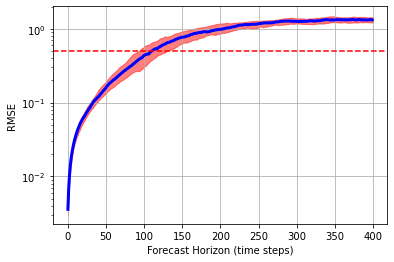

It takes around t = 1.10 for mean error to exceed 0.5


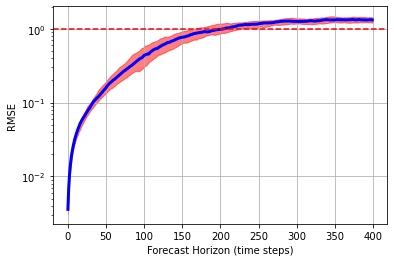

It takes around t = 2.04 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.062
Median NRMSE at t = 0.5: 0.161
Median NRMSE at t = 1: 0.437
Median NRMSE at t = 2: 0.987
Median NRMSE at t = 3: 1.267


In [16]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.2 nn_size = 500

In [17]:
nn_size = 500
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [400, 200, 200]  # Number of epochs for each learning rate

In [18]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 3.45 | Train loss = 0.0036414 | Val loss =  1.5899464
Epoch 20: Time taken = 3.41 | Train loss = 0.0014895 | Val loss =  1.5345340
Epoch 30: Time taken = 3.51 | Train loss = 0.0010478 | Val loss =  1.5109863
Epoch 40: Time taken = 3.41 | Train loss = 0.0006627 | Val loss =  1.3862046
Epoch 50: Time taken = 3.41 | Train loss = 0.0004505 | Val loss =  1.3704602
Epoch 51: Time taken = 3.40 | Train loss = 0.0004397 | Val loss =  1.2608975
Epoch 54: Time taken = 3.41 | Train loss = 0.0004059 | Val loss =  1.1743120
Epoch 60: Time taken = 3.41 | Train loss = 0.0003498 | Val loss =  1.2764462
Epoch 61: Time taken = 3.42 | Train loss = 0.0003401 | Val loss =  1.1642696
Epoch 66: Time taken = 3.43 | Train loss = 0.0003095 | Val loss =  1.1561272
Epoch 70: Time taken = 3.43 | Train loss = 0.0002761 | Val loss =  1.2084490
Epoch 74: Time taken = 3.43 | Train loss = 0.0002645 | Val loss =  1.1479886
Epoch 78: Time taken = 3.43 | Train loss = 0.0002452 

In [19]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
save_obj(mean_pred, "results/lstm", "3_1_2_mu_preds.pkl")

Testing complete. Time taken: 0.80


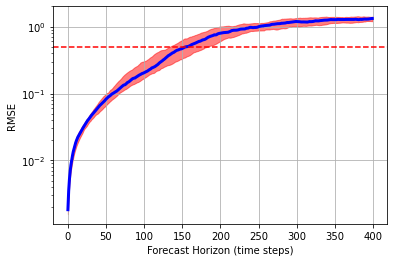

It takes around t = 1.56 for mean error to exceed 0.5


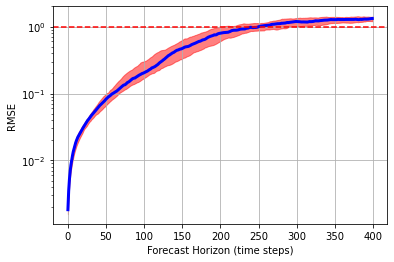

It takes around t = 2.51 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.031
Median NRMSE at t = 0.5: 0.083
Median NRMSE at t = 1: 0.205
Median NRMSE at t = 2: 0.799
Median NRMSE at t = 3: 1.190


In [20]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.3 nn_size = 1000

In [21]:
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [400, 200, 200]  # Number of epochs for each learning rate
nn_size = 1000

In [22]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 9.04 | Train loss = 0.0026123 | Val loss =  1.7186270
Epoch 20: Time taken = 9.03 | Train loss = 0.0012328 | Val loss =  1.5502366
Epoch 30: Time taken = 9.05 | Train loss = 0.0006239 | Val loss =  1.4492000
Epoch 40: Time taken = 9.03 | Train loss = 0.0003672 | Val loss =  1.2934939
Epoch 50: Time taken = 9.04 | Train loss = 0.0002295 | Val loss =  1.1451668
Epoch 51: Time taken = 9.05 | Train loss = 0.0002299 | Val loss =  1.1294261
Epoch 60: Time taken = 9.07 | Train loss = 0.0001781 | Val loss =  1.2711651
Epoch 61: Time taken = 9.07 | Train loss = 0.0001746 | Val loss =  1.1286021
Epoch 63: Time taken = 9.04 | Train loss = 0.0001677 | Val loss =  1.0981977
Epoch 68: Time taken = 9.05 | Train loss = 0.0001477 | Val loss =  1.0494405
Epoch 70: Time taken = 9.04 | Train loss = 0.0001384 | Val loss =  1.1288046
Epoch 77: Time taken = 9.05 | Train loss = 0.0001166 | Val loss =  1.0332257
Epoch 80: Time taken = 9.06 | Train loss = 0.0001160 

In [23]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
save_obj(mean_pred, "results/lstm", "3_1_3_mu_preds.pkl")

Testing complete. Time taken: 1.37


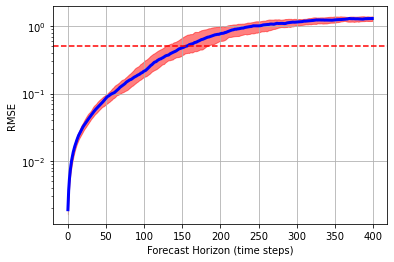

It takes around t = 1.54 for mean error to exceed 0.5


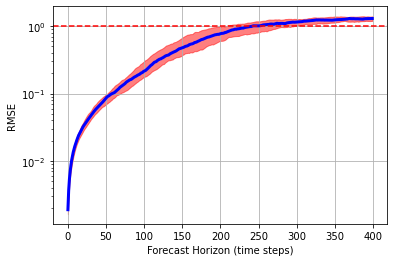

It takes around t = 2.42 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.032
Median NRMSE at t = 0.5: 0.086
Median NRMSE at t = 1: 0.215
Median NRMSE at t = 2: 0.769
Median NRMSE at t = 3: 1.143


In [24]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.4 nn_size = 1500

In [25]:
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [400, 200, 200]  # Number of epochs for each learning rate
nn_size = 1500

In [26]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 16.97 | Train loss = 0.0027568 | Val loss =  1.7221537
Epoch 20: Time taken = 16.98 | Train loss = 0.0010153 | Val loss =  1.5197678
Epoch 30: Time taken = 17.03 | Train loss = 0.0004558 | Val loss =  1.3146151
Epoch 40: Time taken = 17.06 | Train loss = 0.0002888 | Val loss =  1.2686390
Epoch 50: Time taken = 17.00 | Train loss = 0.0001946 | Val loss =  1.2569376
Epoch 51: Time taken = 17.02 | Train loss = 0.0001923 | Val loss =  1.0403228
Epoch 53: Time taken = 17.01 | Train loss = 0.0001685 | Val loss =  1.0297538
Epoch 60: Time taken = 17.01 | Train loss = 0.0001451 | Val loss =  1.1469302
Epoch 63: Time taken = 17.01 | Train loss = 0.0001376 | Val loss =  1.0244701
Epoch 70: Time taken = 17.00 | Train loss = 0.0001169 | Val loss =  1.1405401
Epoch 77: Time taken = 17.06 | Train loss = 0.0000920 | Val loss =  1.0237386
Epoch 80: Time taken = 17.07 | Train loss = 0.0000867 | Val loss =  1.0449178
Epoch 85: Time taken = 17.06 | Train loss

In [27]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
save_obj(mean_pred, "results/lstm", "3_1_4_mu_preds.pkl")

Testing complete. Time taken: 2.09


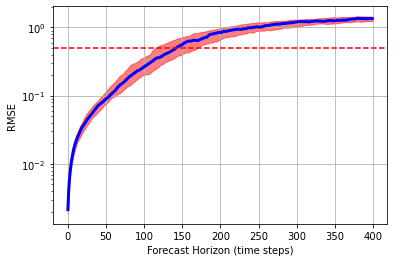

It takes around t = 1.42 for mean error to exceed 0.5


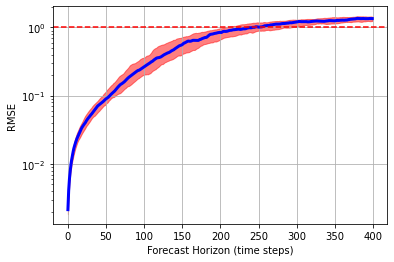

It takes around t = 2.42 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.036
Median NRMSE at t = 0.5: 0.090
Median NRMSE at t = 1: 0.267
Median NRMSE at t = 2: 0.845
Median NRMSE at t = 3: 1.205


In [28]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

## 3.2 L_forecast_train + L_past

**Parameters**
- nn_size = 1000
- L_forecast_train = [1, 8, 16]
- L_past = [4, 8, 16]

In [29]:
nn_size = 500
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [400, 200, 200]  # Number of epochs for each learning rate

### 3.2.1 L_forecast_train = 4, L_past = 1

In [32]:
L_forecast_train = 4; L_past = 1

In [33]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 1.32 | Train loss = 0.0018244 | Val loss =  1.8862066
Epoch 20: Time taken = 1.30 | Train loss = 0.0006444 | Val loss =  1.5937916
Epoch 30: Time taken = 1.30 | Train loss = 0.0003681 | Val loss =  1.6631552
Epoch 40: Time taken = 1.31 | Train loss = 0.0002594 | Val loss =  1.4016538
Epoch 50: Time taken = 1.31 | Train loss = 0.0001994 | Val loss =  1.3336357
Epoch 52: Time taken = 1.32 | Train loss = 0.0001924 | Val loss =  1.3145134
Epoch 56: Time taken = 1.41 | Train loss = 0.0001804 | Val loss =  1.3035785
Epoch 58: Time taken = 1.30 | Train loss = 0.0001707 | Val loss =  1.2897203
Epoch 60: Time taken = 1.31 | Train loss = 0.0001690 | Val loss =  1.2784632
Epoch 64: Time taken = 1.30 | Train loss = 0.0001580 | Val loss =  1.2386074
Epoch 70: Time taken = 1.32 | Train loss = 0.0001466 | Val loss =  1.2848353
Epoch 71: Time taken = 1.31 | Train loss = 0.0001453 | Val loss =  1.2204157
Epoch 75: Time taken = 1.33 | Train loss = 0.0001354 

In [34]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
save_obj(mean_pred, "results/lstm", "3_2_1_mu_preds.pkl")

Testing complete. Time taken: 0.68


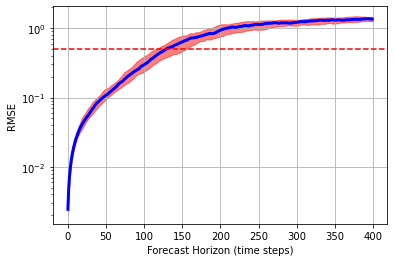

It takes around t = 1.29 for mean error to exceed 0.5


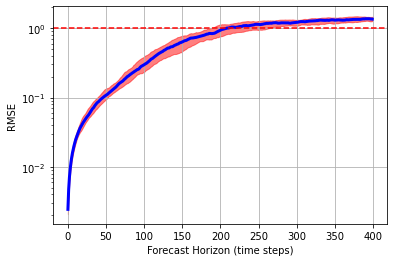

It takes around t = 2.08 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.044
Median NRMSE at t = 0.5: 0.108
Median NRMSE at t = 1: 0.298
Median NRMSE at t = 2: 0.939
Median NRMSE at t = 3: 1.220


In [35]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.2 L_forecast_train = 4, L_past = 4

In [36]:
L_forecast_train = 4; L_past = 4

In [37]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 2.24 | Train loss = 0.0013120 | Val loss =  1.7131908
Epoch 20: Time taken = 2.24 | Train loss = 0.0006074 | Val loss =  1.5966765
Epoch 30: Time taken = 2.24 | Train loss = 0.0002894 | Val loss =  1.5627478
Epoch 40: Time taken = 2.26 | Train loss = 0.0001909 | Val loss =  1.4374537
Epoch 50: Time taken = 2.25 | Train loss = 0.0001400 | Val loss =  1.3068198
Epoch 53: Time taken = 2.26 | Train loss = 0.0001313 | Val loss =  1.2266666
Epoch 58: Time taken = 2.25 | Train loss = 0.0001170 | Val loss =  1.1466060
Epoch 60: Time taken = 2.25 | Train loss = 0.0001101 | Val loss =  1.2489958
Epoch 70: Time taken = 2.25 | Train loss = 0.0000914 | Val loss =  1.1883199
Epoch 74: Time taken = 2.26 | Train loss = 0.0000851 | Val loss =  1.1276053
Epoch 79: Time taken = 2.25 | Train loss = 0.0000806 | Val loss =  1.1225288
Epoch 80: Time taken = 2.25 | Train loss = 0.0000768 | Val loss =  1.1971958
Epoch 83: Time taken = 2.25 | Train loss = 0.0000740 

In [38]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
save_obj(mean_pred, "results/lstm", "3_2_2_mu_preds.pkl")

Testing complete. Time taken: 0.68


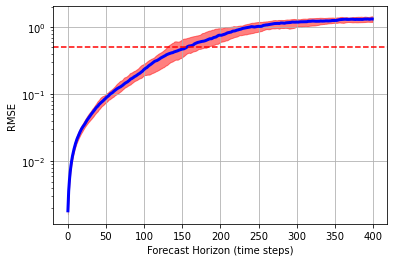

It takes around t = 1.56 for mean error to exceed 0.5


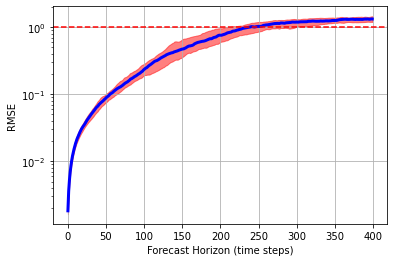

It takes around t = 2.39 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.033
Median NRMSE at t = 0.5: 0.089
Median NRMSE at t = 1: 0.235
Median NRMSE at t = 2: 0.757
Median NRMSE at t = 3: 1.188


In [39]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.3 L_forecast_train = 4, L_past = 8

In [40]:
L_forecast_train = 4; L_past = 8

In [41]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 3.25 | Train loss = 0.0013346 | Val loss =  1.7498604
Epoch 20: Time taken = 3.27 | Train loss = 0.0007312 | Val loss =  1.7750369
Epoch 30: Time taken = 3.26 | Train loss = 0.0006177 | Val loss =  1.7528903
Epoch 40: Time taken = 3.47 | Train loss = 0.0005713 | Val loss =  1.7001117
Epoch 50: Time taken = 3.27 | Train loss = 0.0005383 | Val loss =  1.7680783
Epoch 60: Time taken = 3.27 | Train loss = 0.0005212 | Val loss =  1.7228931
Epoch 70: Time taken = 3.28 | Train loss = 0.0005058 | Val loss =  1.7031865
Epoch 80: Time taken = 3.28 | Train loss = 0.0004926 | Val loss =  1.6857640
Epoch 90: Time taken = 3.33 | Train loss = 0.0004855 | Val loss =  1.7158064
Epoch 100: Time taken = 3.28 | Train loss = 0.0004768 | Val loss =  1.7946613
Epoch 104: Time taken = 3.27 | Train loss = 0.0004477 | Val loss =  1.6521841
Epoch 105: Time taken = 3.28 | Train loss = 0.0003889 | Val loss =  1.6492461
Epoch 106: Time taken = 3.28 | Train loss = 0.0003

In [42]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
save_obj(mean_pred, "results/lstm", "3_2_3_mu_preds.pkl")

Testing complete. Time taken: 0.70


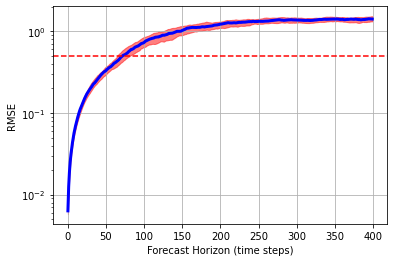

It takes around t = 0.72 for mean error to exceed 0.5


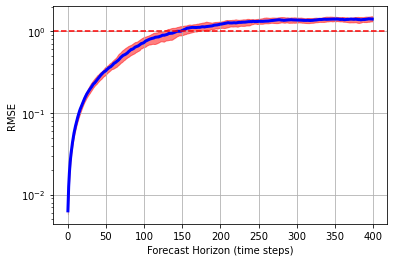

It takes around t = 1.49 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.136
Median NRMSE at t = 0.5: 0.331
Median NRMSE at t = 1: 0.730
Median NRMSE at t = 2: 1.220
Median NRMSE at t = 3: 1.368


In [43]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.4 L_forecast_train = 8, L_past = 1

In [44]:
L_forecast_train = 8; L_past = 1

In [45]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 2.43 | Train loss = 0.0045707 | Val loss =  1.6616775
Epoch 20: Time taken = 2.43 | Train loss = 0.0017513 | Val loss =  1.5420898
Epoch 30: Time taken = 2.43 | Train loss = 0.0010707 | Val loss =  1.4409338
Epoch 40: Time taken = 2.43 | Train loss = 0.0007665 | Val loss =  1.3806090
Epoch 50: Time taken = 2.43 | Train loss = 0.0005860 | Val loss =  1.4171841
Epoch 51: Time taken = 2.44 | Train loss = 0.0005862 | Val loss =  1.2384014
Epoch 54: Time taken = 2.47 | Train loss = 0.0005295 | Val loss =  1.2256229
Epoch 59: Time taken = 2.48 | Train loss = 0.0004902 | Val loss =  1.1917681
Epoch 60: Time taken = 2.43 | Train loss = 0.0004846 | Val loss =  1.3554680
Epoch 70: Time taken = 2.43 | Train loss = 0.0004040 | Val loss =  1.2834706
Epoch 74: Time taken = 2.43 | Train loss = 0.0003847 | Val loss =  1.1783351
Epoch 75: Time taken = 2.44 | Train loss = 0.0003690 | Val loss =  1.1412125
Epoch 80: Time taken = 2.44 | Train loss = 0.0003419 

In [46]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
save_obj(mean_pred, "results/lstm", "3_2_4_mu_preds.pkl")

Testing complete. Time taken: 0.69


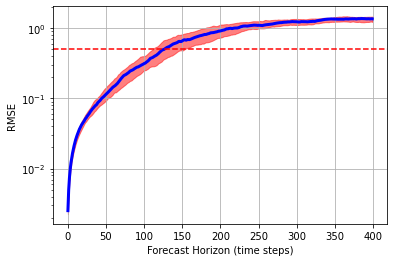

It takes around t = 1.27 for mean error to exceed 0.5


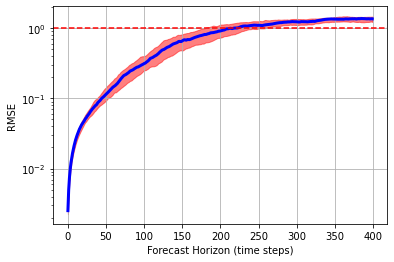

It takes around t = 2.23 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.045
Median NRMSE at t = 0.5: 0.114
Median NRMSE at t = 1: 0.312
Median NRMSE at t = 2: 0.907
Median NRMSE at t = 3: 1.224


In [47]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.5 L_forecast_train = 8, L_past = 4

In [48]:
L_forecast_train = 8; L_past = 4

In [49]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 3.39 | Train loss = 0.0036414 | Val loss =  1.5899464
Epoch 20: Time taken = 3.37 | Train loss = 0.0014895 | Val loss =  1.5345340
Epoch 30: Time taken = 3.38 | Train loss = 0.0010478 | Val loss =  1.5109863
Epoch 40: Time taken = 3.37 | Train loss = 0.0006627 | Val loss =  1.3862046
Epoch 50: Time taken = 3.38 | Train loss = 0.0004505 | Val loss =  1.3704602
Epoch 51: Time taken = 3.38 | Train loss = 0.0004397 | Val loss =  1.2608975
Epoch 54: Time taken = 3.37 | Train loss = 0.0004059 | Val loss =  1.1743120
Epoch 60: Time taken = 3.54 | Train loss = 0.0003498 | Val loss =  1.2764462
Epoch 61: Time taken = 3.38 | Train loss = 0.0003401 | Val loss =  1.1642696
Epoch 66: Time taken = 3.37 | Train loss = 0.0003095 | Val loss =  1.1561272
Epoch 70: Time taken = 3.42 | Train loss = 0.0002761 | Val loss =  1.2084490
Epoch 74: Time taken = 3.47 | Train loss = 0.0002645 | Val loss =  1.1479886
Epoch 78: Time taken = 3.36 | Train loss = 0.0002452 

In [50]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
save_obj(mean_pred, "results/lstm", "3_2_5_mu_preds.pkl")

Testing complete. Time taken: 0.66


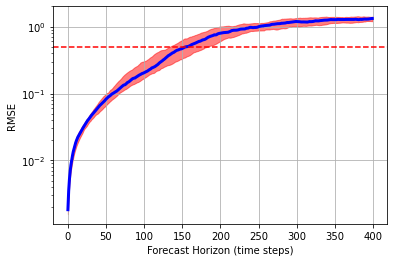

It takes around t = 1.56 for mean error to exceed 0.5


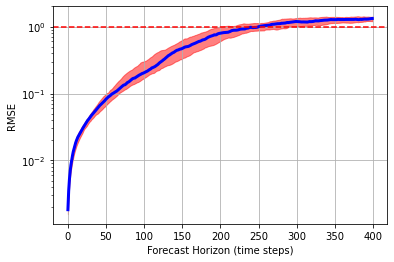

It takes around t = 2.51 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.031
Median NRMSE at t = 0.5: 0.083
Median NRMSE at t = 1: 0.205
Median NRMSE at t = 2: 0.799
Median NRMSE at t = 3: 1.190


In [51]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.6 L_forecast_train = 8, L_past = 8

In [52]:
L_forecast_train = 8; L_past = 8

In [53]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 4.42 | Train loss = 0.0036141 | Val loss =  1.5409343
Epoch 20: Time taken = 4.41 | Train loss = 0.0015020 | Val loss =  1.5751284
Epoch 30: Time taken = 4.40 | Train loss = 0.0010986 | Val loss =  1.5610319
Epoch 40: Time taken = 4.40 | Train loss = 0.0009504 | Val loss =  1.5211991
Epoch 50: Time taken = 4.41 | Train loss = 0.0008485 | Val loss =  1.4636256
Epoch 60: Time taken = 4.41 | Train loss = 0.0007932 | Val loss =  1.4642599
Epoch 70: Time taken = 4.40 | Train loss = 0.0007665 | Val loss =  1.4720072
Epoch 80: Time taken = 4.40 | Train loss = 0.0007191 | Val loss =  1.4303160
Epoch 90: Time taken = 4.41 | Train loss = 0.0007000 | Val loss =  1.4896628
Epoch 100: Time taken = 4.41 | Train loss = 0.0006769 | Val loss =  1.4691471
Epoch 110: Time taken = 4.42 | Train loss = 0.0006670 | Val loss =  1.4368279
Epoch 120: Time taken = 4.40 | Train loss = 0.0006516 | Val loss =  1.4197968
Epoch 130: Time taken = 4.41 | Train loss = 0.0006

In [54]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
save_obj(mean_pred, "results/lstm", "3_2_6_mu_preds.pkl")

Testing complete. Time taken: 0.66


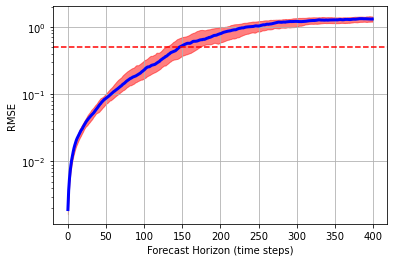

It takes around t = 1.47 for mean error to exceed 0.5


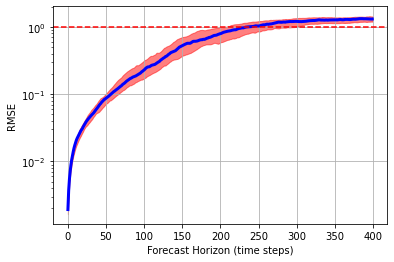

It takes around t = 2.36 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.033
Median NRMSE at t = 0.5: 0.087
Median NRMSE at t = 1: 0.230
Median NRMSE at t = 2: 0.794
Median NRMSE at t = 3: 1.207


In [55]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.7 L_forecast_train = 16, L_past = 1

In [56]:
L_forecast_train = 16; L_past = 1

In [57]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 4.70 | Train loss = 0.0161514 | Val loss =  1.5818924
Epoch 20: Time taken = 4.71 | Train loss = 0.0051772 | Val loss =  1.5027075
Epoch 30: Time taken = 4.70 | Train loss = 0.0032418 | Val loss =  1.4001677
EARLY STOPPING. Epoch 31: Train loss = 0.0032703 | Val loss =  1.3729750
Best Validation MSE: 0.9875648
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 4.70 | Train loss = 0.0085929 | Val loss =  1.5993990
Epoch 20: Time taken = 4.70 | Train loss = 0.0039833 | Val loss =  1.4958969
Epoch 30: Time taken = 4.70 | Train loss = 0.0027664 | Val loss =  1.3437463
Epoch 40: Time taken = 4.70 | Train loss = 0.0019778 | Val loss =  1.2781513
Epoch 50: Time taken = 4.70 | Train loss = 0.0016303 | Val loss =  1.2088770
Epoch 51: Time taken = 4.70 | Train loss = 0.0015058 | Val loss =  1.1822070
Epoch 60: Time taken = 4.70 | Train loss = 0.0012462 | Val loss =  1.2476815
Epoch 61: Time taken = 4.69 | Train loss = 0.0012025 | Val loss =  1.1734076
E

In [58]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
save_obj(mean_pred, "results/lstm", "3_2_7_mu_preds.pkl")

Testing complete. Time taken: 0.71


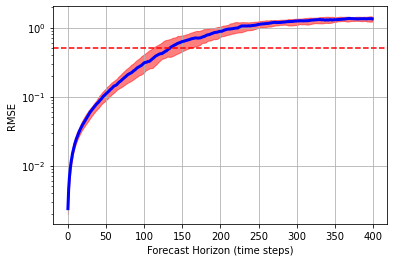

It takes around t = 1.34 for mean error to exceed 0.5


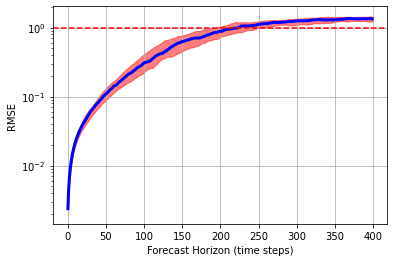

It takes around t = 2.24 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.040
Median NRMSE at t = 0.5: 0.110
Median NRMSE at t = 1: 0.308
Median NRMSE at t = 2: 0.881
Median NRMSE at t = 3: 1.243


In [59]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.8 L_forecast_train = 16, L_past = 4

In [60]:
L_forecast_train = 16; L_past = 4

In [61]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 5.61 | Train loss = 0.0148719 | Val loss =  1.5065755
Epoch 20: Time taken = 5.61 | Train loss = 0.0043700 | Val loss =  1.4456854
Epoch 30: Time taken = 5.62 | Train loss = 0.0027162 | Val loss =  1.3126334
EARLY STOPPING. Epoch 31: Train loss = 0.0026890 | Val loss =  1.4136941
Best Validation MSE: 0.9597812
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 5.59 | Train loss = 0.0071378 | Val loss =  1.4817468
Epoch 20: Time taken = 5.59 | Train loss = 0.0031589 | Val loss =  1.4550264
Epoch 30: Time taken = 5.60 | Train loss = 0.0022231 | Val loss =  1.4297832
Epoch 40: Time taken = 5.61 | Train loss = 0.0017888 | Val loss =  1.3250618
Epoch 50: Time taken = 5.60 | Train loss = 0.0015639 | Val loss =  1.2682081
Epoch 60: Time taken = 5.59 | Train loss = 0.0011665 | Val loss =  1.2781467
Epoch 70: Time taken = 5.61 | Train loss = 0.0009895 | Val loss =  1.2658410
Epoch 71: Time taken = 5.61 | Train loss = 0.0010386 | Val loss =  1.1398195
E

In [62]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
save_obj(mean_pred, "results/lstm", "3_2_8_mu_preds.pkl")

Testing complete. Time taken: 0.69


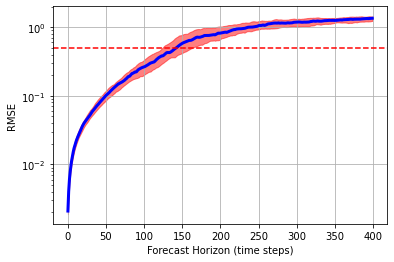

It takes around t = 1.43 for mean error to exceed 0.5


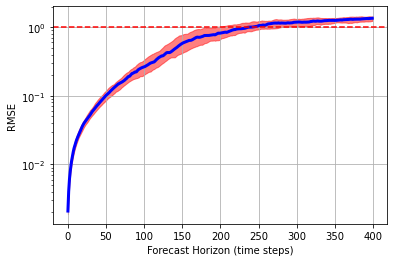

It takes around t = 2.37 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.038
Median NRMSE at t = 0.5: 0.102
Median NRMSE at t = 1: 0.265
Median NRMSE at t = 2: 0.823
Median NRMSE at t = 3: 1.188


In [63]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.9 L_forecast_train = 16, L_past = 8

In [64]:
L_forecast_train = 16; L_past = 8

In [65]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 6.74 | Train loss = 0.0150930 | Val loss =  1.5617294
Epoch 20: Time taken = 6.73 | Train loss = 0.0043523 | Val loss =  1.5643258
Epoch 30: Time taken = 6.71 | Train loss = 0.0027337 | Val loss =  1.4036735
EARLY STOPPING. Epoch 31: Train loss = 0.0026588 | Val loss =  1.3831834
Best Validation MSE: 0.9526972
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 6.72 | Train loss = 0.0072031 | Val loss =  1.5632613
Epoch 20: Time taken = 6.70 | Train loss = 0.0031174 | Val loss =  1.3568255
Epoch 30: Time taken = 6.75 | Train loss = 0.0021677 | Val loss =  1.3574390
Epoch 40: Time taken = 6.74 | Train loss = 0.0017431 | Val loss =  1.3241410
Epoch 50: Time taken = 6.74 | Train loss = 0.0015470 | Val loss =  1.3156933
Epoch 54: Time taken = 6.74 | Train loss = 0.0014293 | Val loss =  1.2559435
Epoch 60: Time taken = 6.76 | Train loss = 0.0013281 | Val loss =  1.2637002
Epoch 62: Time taken = 6.76 | Train loss = 0.0013432 | Val loss =  1.2545747
E

In [66]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
save_obj(mean_pred, "results/lstm", "3_2_9_mu_preds.pkl")

Testing complete. Time taken: 0.73


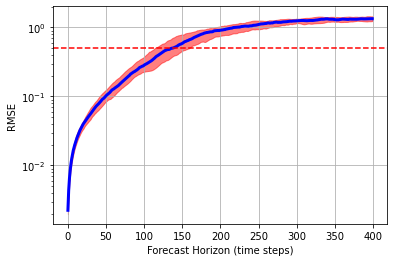

It takes around t = 1.36 for mean error to exceed 0.5


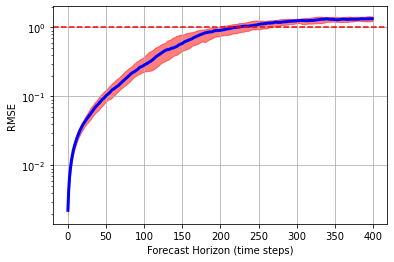

It takes around t = 2.18 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.040
Median NRMSE at t = 0.5: 0.102
Median NRMSE at t = 1: 0.285
Median NRMSE at t = 2: 0.916
Median NRMSE at t = 3: 1.250


In [67]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

# 4. Best Model

nn_size = 500  
L_forecast_train = 4  
L_past = 4

In [12]:
nn_size = 500
L_forecast_train = 4
L_past = 4

b_size = 128 # Batch size
lr_list = [1e-3, 1e-4, 1e-5, 1e-6] # Learning rate schedule
epoch_list = [400, 200, 200, 200]  # Number of epochs for each learning rate

In [18]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list,
                                early_stopping = 50)

Backpropogation start

Epoch 10: Time taken = 2.29 | Train loss = 0.0013160 | Val loss =  1.7073812
Epoch 20: Time taken = 2.30 | Train loss = 0.0006138 | Val loss =  1.5788507
Epoch 30: Time taken = 2.35 | Train loss = 0.0002915 | Val loss =  1.5642031
Epoch 40: Time taken = 2.32 | Train loss = 0.0001949 | Val loss =  1.3992747
Epoch 50: Time taken = 2.30 | Train loss = 0.0001422 | Val loss =  1.3220706
Epoch 53: Time taken = 2.31 | Train loss = 0.0001360 | Val loss =  1.1760775
Epoch 58: Time taken = 2.33 | Train loss = 0.0001173 | Val loss =  1.1587918
Epoch 60: Time taken = 2.31 | Train loss = 0.0001115 | Val loss =  1.3393558
Epoch 69: Time taken = 2.32 | Train loss = 0.0000939 | Val loss =  1.1363643
Epoch 70: Time taken = 2.36 | Train loss = 0.0000928 | Val loss =  1.2206759
Epoch 79: Time taken = 2.32 | Train loss = 0.0000831 | Val loss =  1.1000453
Epoch 80: Time taken = 2.33 | Train loss = 0.0000781 | Val loss =  1.2235817
Epoch 83: Time taken = 2.33 | Train loss = 0.0000754 

In [19]:
mean_pred = get_test_pred(X_test, params, lstm_fx)

Testing complete. Time taken: 1.04


In [21]:
save_obj(params, "results/lstm", "best_params.pkl")
save_obj(mean_pred, "results/lstm", "best_mu_preds.pkl")

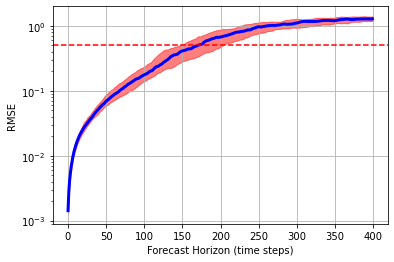

It takes around t = 1.70 for mean error to exceed 0.5


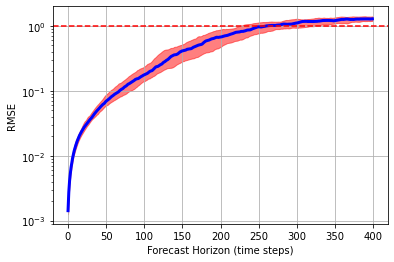

It takes around t = 2.61 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.026
Median NRMSE at t = 0.5: 0.069
Median NRMSE at t = 1: 0.177
Median NRMSE at t = 2: 0.673
Median NRMSE at t = 3: 1.107


In [22]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

# 5. Plot images based on Lyapunov Time

In [17]:
nn_size = 500
_, process, forecast = LSTM(nn_size, data_dim)       # LSTM Network
process_batch = jax.jit(jax.vmap(process, in_axes=(None,0)))
forecast_batch = jax.jit(jax.vmap(forecast, in_axes=(None,0,0,None)), static_argnums=3)

In [18]:
params = load_obj("results/lstm/best_params.pkl")

In [19]:
mean_pred = get_test_pred(X_test, params, (process_batch, forecast_batch))

Testing complete. Time taken: 2.01


In [20]:
save_obj(mean_pred, "results", "lstm_pred.pkl")

In [7]:
mean_pred = load_obj("results/lstm_pred.pkl")

In [8]:
total_lyapunov_time_pred = 4 / LORENZ_LT # Amount of Lyapunov Time in Test set

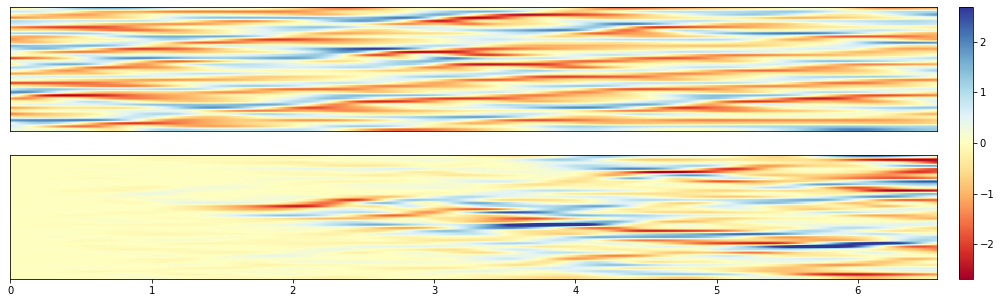

In [13]:
plot_predictions(mean_pred, y_test, total_lyapunov_time_pred, save_name = "lorenz_LSTM", pred_only = True)

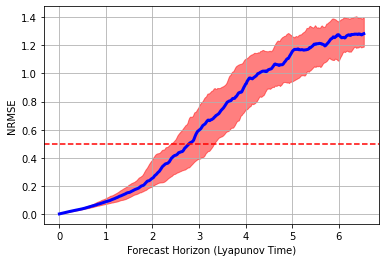

It takes around 2.79 Lyapunov Time for mean error to exceed 0.5

Median NRMSE at 0.5 Lyapunov Time: 0.037
Median NRMSE at 1.0 Lyapunov Time: 0.089
Median NRMSE at 2.0 Lyapunov Time: 0.255
Median NRMSE at 5.0 Lyapunov Time: 1.154


In [18]:
res_single = PointExperimentResultLyapunov(mean_pred - y_test, "lorenz")
res_single.plot_rmse(save_name = "Figure3-4_LSTM_Prediction_Horizon")
print()
res_single.get_loss()